In [15]:
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
dtup = 18, 1

In [3]:
fname = '.'.join([str(x) for x in dtup]) + '.lfpsurvdata.csv'
dat = pd.read_csv('data/' + fname, index_col=0)

In [4]:
dat.head()

,event,rel_time,ttype2,ttype3,delta.17,delta.18,delta.19,delta.20,delta.21,delta.22,...,gamma.39,gamma.40,gamma.41,gamma.42,gamma.43,gamma.44,gamma.45,gamma.46,gamma.47,gamma.48
time,,,,,,,,,,,,,,,,,,,,,
43.7,0,0.1,0,0,5.026050,-0.523085,-0.787669,-0.575848,-0.726836,-0.333366,...,0.000955,4.412614,0.269752,5.623845,3.653679,5.589207,28.640443,2.451512,3.710000,4.965032
43.8,0,0.2,0,0,3.019698,-1.067814,-0.938506,-0.406301,1.679198,-0.155690,...,3.162979,4.351407,-0.283512,7.351240,10.349001,5.382056,14.569021,0.279645,4.727535,5.027285
43.9,0,0.3,0,0,6.153590,1.777577,0.376977,-0.035729,-0.005667,0.952882,...,0.022839,6.523245,-0.119423,5.129595,5.477548,6.768638,24.722964,0.880289,3.051169,5.069035
44.0,0,0.4,0,0,2.218311,6.718173,3.273797,0.692362,1.840646,-0.187845,...,1.476431,3.412023,0.081117,6.187109,5.399819,4.730044,22.151299,2.143819,2.288860,4.215069
44.1,0,0.5,0,0,-0.668973,3.087369,2.018808,0.738372,-0.559480,-0.902331,...,2.066189,3.385899,-0.248409,3.372943,7.081889,2.858394,10.646898,0.061307,3.282597,4.443954


In [5]:
# extract some variables
event = dat.event
time = dat['rel_time']
X = dat.drop(['event', 'rel_time'], axis=1)
dt = X.index[1] - X.index[0]
print(X.shape)

(9076, 162)


In [6]:
survival_dat = {'X': X, 'Nobs': X.shape[0], 'M': X.shape[1], 'event': event, 'time': time, 'dt': dt}

In [7]:
def init_fun():
    # return inits for model parameters
    # needed because Cauchy dists result in huge outliers
    return ({'tau_global': 0.1 * np.abs(np.random.randn()), 
             'tau_local': 0.1 * np.abs(np.random.randn(X.shape[1])), 
             'alpha_raw': 0.01 * 2 * (np.random.rand() - 0.5),
             'beta_raw': 0.1 * np.random.randn(X.shape[1]),
             'mu': 0.1 * np.random.randn()
            })

In [8]:
fit = pystan.stan(file='survival.stan', data=survival_dat, iter=2000, thin=5, chains=4, 
                  seed=12345, pars=['tau_global', 'tau_local', 'alpha', 'beta', 'mu'], init=init_fun)

In [9]:
fit

Inference for Stan model: anon_model_d9deda336cd29028f1dcf9c21d9ea990.
4 chains, each with iter=2000; warmup=1000; thin=5; 
post-warmup draws per chain=200, total post-warmup draws=800.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_global       0.01  3.0e-4 7.1e-3 3.8e-3 9.1e-3   0.01   0.02   0.03    570    1.0
tau_local[0]   193.01     7.9  209.0  35.27   75.5 129.95  223.3 745.33    700    1.0
tau_local[1]   304.44   17.36 444.42   56.4 126.23 203.31 364.65 1057.7    655    1.0
tau_local[2]      2.3    0.19    5.3   0.03   0.38   0.89   2.17  14.22    800    1.0
tau_local[3]     3.44    0.49  12.91   0.04   0.47   1.15   2.97   19.3    708    1.0
tau_local[4]     2.21    0.17   4.26   0.04   0.37    0.9   2.23   13.7    661    1.0
tau_local[5]     1.69    0.11    3.2   0.03   0.35   0.87   1.85   7.78    800    1.0
tau_local[6]     3.45    0.25   6.61   0.04   0.51   1.26   3.42  20.07    690    1.0
tau_local[7]     1.83    0.14   3.91   

In [12]:
betas = fit.extract('beta')['beta']

In [45]:
beta_summ = fit.summary('beta')
betas = pd.DataFrame(beta_summ['summary'], index=beta_summ['summary_rownames'], columns=beta_summ['summary_colnames'])

In [46]:
betas

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],1.903615,0.009916,0.253791,1.397996,1.733422,1.886345,2.073901,2.390581,655.0,1.005594
beta[1],3.104387,0.012508,0.337259,2.443437,2.881288,3.100757,3.329863,3.818705,727.0,1.000935
beta[2],0.009945,0.001386,0.039205,-0.044863,-0.003551,0.000942,0.012021,0.113320,800.0,1.001305
beta[3],-0.024736,0.001839,0.051221,-0.176442,-0.030859,-0.004575,0.000858,0.021973,776.0,1.000028
beta[4],-0.009922,0.001298,0.035423,-0.119849,-0.011355,-0.001014,0.003457,0.033667,745.0,0.996464
beta[5],-0.000167,0.000890,0.024901,-0.061426,-0.004988,0.000146,0.006686,0.053227,783.0,1.003129
beta[6],0.027775,0.002057,0.054885,-0.022537,-0.001116,0.003953,0.035070,0.198771,712.0,0.997945
beta[7],0.001337,0.000926,0.026070,-0.054701,-0.006577,0.000024,0.006343,0.069495,793.0,1.000149
beta[8],0.023678,0.001735,0.046954,-0.027617,-0.001453,0.004239,0.034312,0.158212,732.0,0.997267
beta[9],0.005988,0.001101,0.031138,-0.043444,-0.003742,0.000591,0.010630,0.085976,800.0,0.998941


In [55]:
plt.errorbar?

<IPython.core.display.Javascript object>


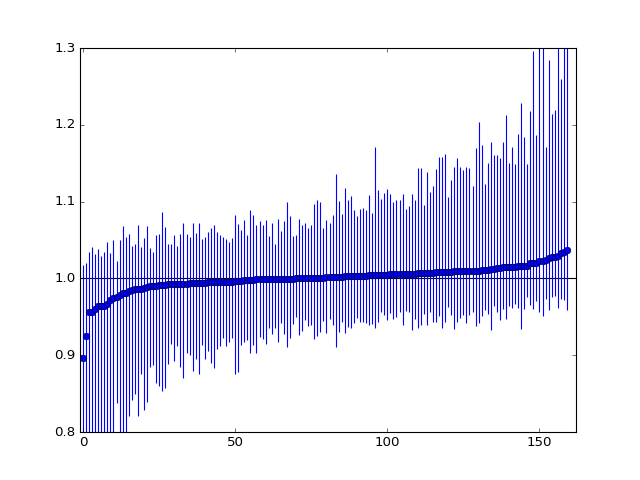

(0.8, 1.3)

In [65]:
# plt.stem(np.sort(beta_means))
# plt.stem(beta_means)
# plt.stem(np.sort(np.exp(beta_means)))
# plt.plot(np.sort(np.exp(betas['mean'])), marker='o', linestyle='None')
b_m = np.exp(betas['mean'])
b_lo = b_m - np.exp(betas['2.5%'])
b_hi = np.exp(betas['97.5%']) - b_m

idx = np.argsort(b_m)
plt.errorbar(np.arange(len(b_m)), b_m[idx], yerr=[b_lo[idx], b_hi[idx]], capthick=0, marker='o', linestyle='None')
plt.axhline(1., color='k', zorder=-1)
plt.xlim(-1, len(b_m))
plt.ylim(0.8, 1.3)